### Stratégie :
On récupère le point de départ, on le région growth.
On fait une recherche sur la couche du dessous sur le centre trouvé précédemment puis en région growing sur les plus proches voisins jusqu'à trouver un point d'intensité similaire +-5% puis on le region growth. On limite le region growing à la taille de la tache trouvée sur la précédente couche + 1 voisin
Si on ne trouve rien dans cette zone, on met un False dans la liste et on descend d'une couche avec une tolérance d'intensité de +1% et d'un voisin supplémentaire 

In [1]:
import SimpleITK as sitk
import itk
import itkwidgets 
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import ipywidgets as widgets
import cv2
from tqdm.notebook import tqdm
from napari.utils.colormaps import colormap_utils as cu
from functools import partial
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas
from matplotlib.figure import Figure
import copy

In [2]:

import math


def regionSearch(image,point,searchRadius,minValue):
    search_memory = np.zeros_like(image, dtype=np.uint8)
    queue = [point]
    while queue:
        x, y = queue.pop(0)
        if search_memory[y, x] == 0:
            # Vérifier si la valeur du pixel est dans la plage acceptable
            # if point == (265,208):
            #     print(x, y)
            #     print(point)
            if int(image[y, x]) > minValue: #and int(image[y, x]) < maxValue:
                return (x,y)
            else:
                search_memory[y, x] = 1
            # Ajouter les voisins à la pile
            if abs(y-point[1]) < searchRadius+5 and abs(x-point[0]) < searchRadius+5:
                for i in range(-1, 2):
                    for j in range(-1, 2):
                        if 0 <= x + i < image.shape[1] and 0 <= y + j < image.shape[0]:
                            queue.append((x + i, y + j))
    #print("Radius was "+str(searchRadius)+" origin was "+str(point) +" and value was "+str(minValue))
    return (-1,-1)

def regionGrowing(image,point,nested_intensity,mean_radius=-1,alpha=0.60,exclusion_zone=None):

    segmented = np.zeros_like(image, dtype=np.uint8)

    # Initialiser la pile pour la croissance de la région
    stack = [point]

    # Récupérer la valeur du pixel du point de départ
    seed_value = nested_intensity.get_average()
    sum = 0
    if mean_radius > -1:
        unrealistic_area = 2 * np.pi * math.pow(mean_radius,2) * 2
    else:
        unrealistic_area = np.pow(10,7)

    while stack:
        x, y = stack.pop()
        # Vérifier si le pixel est déjà visité
        if segmented[y, x] == 0:
            # Vérifier si la valeur du pixel est dans la plage acceptable
            if image[y, x] >= seed_value*alpha:
                if isinstance(exclusion_zone,type(None)) or not any([cv2.pointPolygonTest(exclusion_zone[i] if len(exclusion_zone[i])>10 else np.array([[0,0],[1,1]]),(x,y),False) >= 0 for i in range(len(exclusion_zone))]):
                    # Ajouter le pixel à la région
                    segmented[y, x] = 255
                    sum += 1
                    # Ajouter les voisins à la pile
                    for i in range(-1, 2):
                        for j in range(-1, 2):
                            if 0 <= x + i < image.shape[1] and 0 <= y + j < image.shape[0]:
                                stack.append((x + i, y + j))

    
    contours, _ = cv2.findContours(segmented, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if len(contours)>0:
        rect = cv2.minAreaRect(contours[0])
        contourBoundingWidth = max(rect[1])/2 #rect width
        # check if contour is big enough and thus anormal
        if contourBoundingWidth > 5 and (contourBoundingWidth > mean_radius * 3 or sum > unrealistic_area):
            if sum > 2000:
                #Bigger than the abdominal aorta
                return list()
            segmented = np.zeros_like(image, dtype=np.uint8)
            cv2.circle(segmented,point,int(mean_radius),255)
            contours, _ = cv2.findContours(segmented, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            return contours[0]
        # else ok
        return contours[0]
    else:
        # print("target was "+str(point))
        # print("targeted intesity was"+str(seed_value))
        # print("not found")
        return list()
    

In [3]:
import time


class RunningAverage:
    def __init__(self,sum=0,count=0,last=None):
        self.sum = sum
        self.count = count
        self.last = last
        

    def add_number(self, number):
        self.sum += number
        self.last = number
        self.count += 1

    def get_average(self):
        if self.count == 0:
            return 0 
        return self.sum / self.count
    
    def split(self):
        if self.count > 0:
            self.sum /= 4
            self.count /= 2
        return self
    
    def get_last(self):
        return self.last
    
    def copy(self):
        return copy.deepcopy(self)
    
    def __str__(self) -> str:
        return str(self.get_average())+" ("+str(self.count)+")"
    
class NestedAverage:
    def __init__(self,numbers=list(),limit=10,average=0,count=0):
        self.limit = limit
        self.average = average
        self.count = count
        self.numbers = numbers
        if self.average == 0 and self.count == 0:
            self.numbers = []
    
    def add_number(self, number):
        self.numbers.append(number)
        if self.count > self.limit:
            self.numbers.pop(0)
        else:
            self.count += 1
        self.average = sum(self.numbers)/self.count

    def get_average(self):
        return self.average
    
    def get_last(self):
        return self.numbers[-1]
    
    def copy(self):
        return copy.deepcopy(self)

class NetworkEngine:
    def __init__(self,image,max_depth):
        self.image = image
        self.max_depth = max_depth
        self.network_manager = NetworkManager(max_depth)
        self.stack = list()
        self.branch_depth = [max_depth-1]
        # if a branch has a value < current depth in this array, this branch is monitored until the registered depth to not merge with another one
        self.branch_monitored_depth = [max_depth]
        self.branch_protected_split = [max_depth]
        self.current_depth = max_depth-1
        self.alpha = 0.6 #alpha >= beta
        self.beta = 0.6 #similarity score
        self.pbar = tqdm(total=max_depth-1)

    def get_new_branch(self,parent_branch_id):
        child_id = self.network_manager.get_new_branch(parent_branch_id)
        self.branch_depth.append(self.branch_depth[parent_branch_id])
        self.branch_monitored_depth.append(self.max_depth)
        self.branch_protected_split.append(self.branch_depth[parent_branch_id])#TODO add -20
        return child_id
    
    def success_split(self,parent_branch,new_target,child_depth,exclusion_radius):
        self.network_manager.set_branch_target(parent_branch,new_target)
        print("SUCCESS SPLIT PARENT "+str(parent_branch))
        self.network_manager.branch_mean_radius[parent_branch] = RunningAverage(exclusion_radius,1,exclusion_radius)
        self.branch_monitored_depth[parent_branch] = child_depth
        self.branch_protected_split[parent_branch] = child_depth
        #Rollback branch 1 if success
        self.branch_depth[parent_branch]+=1
        self.network_manager.network[self.branch_depth[parent_branch]].remove(next((area for area in self.network_manager.network[self.branch_depth[parent_branch]] if area.branch_id == parent_branch),None))

    def explore(self,branch_id,iteration=1,excluded=None,onsuccess=None):
        multi = True if iteration > 1 else False
        for i in range(iteration):
            foundTarget = regionSearch(self.image[self.branch_depth[branch_id],:,:],self.network_manager.get_branch_target(branch_id),self.network_manager.get_mean_radius(branch_id).get_average(),self.network_manager.get_nested_intensity(branch_id).get_average()*self.alpha)
            if not isinstance(excluded,type(None)):
                #Case exploring a newly splitted branch
                tube_contour = regionGrowing(self.image[self.branch_depth[branch_id],:,:],foundTarget,self.network_manager.get_nested_intensity(branch_id),self.network_manager.get_mean_radius(branch_id).get_average(),self.beta,excluded)
            elif(self.branch_monitored_depth[branch_id]<self.branch_depth[branch_id]):
                #Case a splitted branch has succeed and we do not want it to merge with parent
                excluded = list()
                for area in self.network_manager.network[self.branch_depth[branch_id]]:
                    excluded.append(area.contour)
                tube_contour = regionGrowing(self.image[self.branch_depth[branch_id],:,:],foundTarget,self.network_manager.get_nested_intensity(branch_id),self.network_manager.get_mean_radius(branch_id).get_average(),self.beta,excluded)
            else:
                tube_contour = regionGrowing(self.image[self.branch_depth[branch_id],:,:],foundTarget,self.network_manager.get_nested_intensity(branch_id),self.network_manager.get_mean_radius(branch_id).get_average(),self.beta)
            if len(tube_contour)==0:
                self.branch_depth[branch_id] = 0
                if self.network_manager.branch_length[branch_id] < 20:
                    self.network_manager.remove_branch(branch_id)
                break
            center, radius = cv2.minEnclosingCircle(tube_contour)
            self.network_manager.add_label((self.branch_depth[branch_id],center[1],center[0]),
                                           str(round(radius/self.network_manager.get_mean_radius(branch_id).get_average(),2))+","+
                                           str(round(self.network_manager.get_mean_radius(branch_id).get_average(),2))+","+
                                           str(round(self.network_manager.get_nested_intensity(branch_id).get_average(),2)))
            
            if not multi and radius > 3 and self.branch_protected_split[branch_id] > self.branch_depth[branch_id] and (radius < self.network_manager.get_mean_radius(branch_id).get_average()*0.65 
                              or radius/self.network_manager.get_mean_radius(branch_id).get_last() < 0.7):
                print("Splitted "+str(branch_id)+" because protected until "+str(self.branch_protected_split[branch_id]))
                print("Found target is "+str(foundTarget)+" radius is "+str(radius))
                #We suspect a splitted vessel
                last_radius = self.network_manager.get_mean_radius(branch_id).get_last()
                #We try to fit an rectangle to get the split orientation
                tube_contour = self.network_manager.get_last_from_branch(branch_id).contour
                rect = cv2.minAreaRect(tube_contour)
                rect_points = cv2.boxPoints(rect).astype(int)
                # 2---------3 
                # |   RECT  | then offset_a
                # 1---------0
                # 2---------1 
                # |   RECT  | then offset_b
                # 3---------0
                offset_a = np.subtract(rect_points[1],rect_points[0]) #orientation vector
                offset_b = np.subtract(rect_points[3],rect_points[0])
                if np.sum(np.abs(offset_a)) > np.sum(np.abs(offset_b)):
                    offset = offset_a 
                else:
                    offset = offset_b
                pixel_1 = (rect[0] + offset/4).astype(int)
                pixel_2 = (rect[0] - offset/4).astype(int)
                rect_points = np.append(rect_points,pixel_1)
                rect_points = np.append(rect_points,pixel_2)

                self.network_manager.append_to_debug(self.branch_depth[branch_id],rect_points.reshape(6,1,2))

                exclusion_radius = max(rect[1])/4 #rect width
                #x_offset = int(last_radius/2)
                #pixel_1 = (self.network_manager.get_branch_target(branch_id)[0]-x_offset,self.network_manager.get_branch_target(branch_id)[1])
                #Build exclusion zone
                template = np.zeros((self.image.shape[1],self.image.shape[2]),np.uint8)
                cv2.circle(template,pixel_1,int(exclusion_radius),255)
                contours, _ = cv2.findContours(template, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
                exclusion_zone = contours #cv2.pointPolygonTest()
                
                #Not a split, branch just disappear
                if(exclusion_radius < 1):
                    self.branch_depth[branch_id] = 0
                    print(str(branch_id)+"stop because exclusion contours was "+str(contours))
                    if self.network_manager.branch_length[branch_id] < 20:
                        self.network_manager.remove_branch(branch_id)
                else:
                    self.network_manager.append_to_debug(self.branch_depth[branch_id],contours[0])
                    #pixel_2 = (self.network_manager.get_branch_target(branch_id)[0]+x_offset,self.network_manager.get_branch_target(branch_id)[1])
                    #Creating a new branch with a new target
                    target_2_branch_id = self.get_new_branch(branch_id)
                    print("Create branch id :"+str(target_2_branch_id))
                    self.network_manager.set_branch_target(target_2_branch_id,pixel_2)
                    self.network_manager.get_mean_radius(target_2_branch_id).add_number(exclusion_radius)
                    #Exploring 20 frames of new branch with a success callback for parent branch
                    self.stack.append([target_2_branch_id,20,exclusion_zone,partial(self.success_split, branch_id, pixel_1,self.branch_depth[branch_id]-20,exclusion_radius)])
                    #In case branch failed we set up parent branch to continue, these data will be rollback if child branch succeed
                    self.network_manager.append_to_network(self.branch_depth[branch_id],branch_id,tube_contour)
                    self.branch_depth[branch_id]-=1
                    self.network_manager.set_branch_target(branch_id,center)
            
            else:
                if radius == 0:
                    self.branch_depth[branch_id] = 0
                    if self.network_manager.branch_length[branch_id] < 20:
                        self.network_manager.remove_branch(branch_id)
                    break
                self.network_manager.append_to_network(self.branch_depth[branch_id],branch_id,tube_contour)
                self.branch_depth[branch_id]-=1
                self.network_manager.set_branch_target(branch_id,center)
                self.network_manager.get_nested_intensity(branch_id).add_number(self.image[self.branch_depth[branch_id],self.network_manager.get_branch_target(branch_id)[1],self.network_manager.get_branch_target(branch_id)[0]])
                self.network_manager.get_mean_radius(branch_id).add_number(radius)
        if multi and i == iteration-1:
            onsuccess()
        return None
        
    def explore_all(self):
        for i in range(len(self.branch_depth)): 
            #print(str(self.network_manager.branch_mean_radius[i]))   
            if self.branch_depth[i] >= self.current_depth:
                for j in range(self.branch_depth[i] - self.current_depth + 1):
                    self.stack.extend([[i]])
        #print()
    def run(self):
        self.explore_all()
        while self.current_depth > 900:#1120:
            while len(self.stack) > 0:
                exploring_parameters = self.stack.pop()
                self.explore(*exploring_parameters)
                #print(str(self.stack)+" : "+str(time.time()))
            self.current_depth -= 1
            self.pbar.update(1)
            self.pbar.set_description("Searching region %s" % str(self.branch_depth))
            self.explore_all()
    
    def reverse_run(self,target):
        #TODO c'est ici
        return False
    

class NetworkManager:
    def __init__(self,depth):
        self.last_branch_id = 0
        self.network = list()
        self.debug = list()
        self.label = list()
        self.label_coord = list()
        for i in range(depth):
            self.network.append(list())
            self.debug.append(list())
        self.branch_length = [0]
        self.branch_target = [0]
        self.branch_list = [0]
        self.branch_mean_radius = [RunningAverage()]
        self.branch_nested_intensity = [NestedAverage()]
        
    def get_new_branch(self,parent_branch_id=0):
        self.last_branch_id = self.last_branch_id+1
        self.branch_length.append(0)
        self.branch_target.append(0)
        self.branch_list.append(self.last_branch_id)
        self.branch_mean_radius.append(RunningAverage())
        self.branch_nested_intensity.append(self.branch_nested_intensity[parent_branch_id].copy())
        return self.last_branch_id
    
    def get_mean_radius(self,branch_id):
        return self.branch_mean_radius[branch_id]

    def get_nested_intensity(self,branch_id):
        return self.branch_nested_intensity[branch_id]

    def get_branch_target(self,branch_id):
        return self.branch_target[branch_id]

    def set_branch_target(self,branch_id,target):
        self.branch_target[branch_id] = (int(target[0]),int(target[1]))

    def append_to_network(self,depth,branch_id,contour,predicted=False):
        self.network[depth].append(NetworkManagerArea(branch_id,contour,predicted))
        self.branch_length[branch_id]+=1
    
    def append_to_debug(self,depth,contour):
        self.debug[depth].append(NetworkManagerArea(-1,contour,False))

    def add_label(self,coord,text):
        text_dict = {
    'string': text,
    'size': 10,
    'color': 'green',
    'translation': np.array([0, -10])
}
        self.label.append(text)
        self.label_coord.append(np.array(coord))

    def get_branchs(self):
        return self.branch_list

    def get_branch(self,branch_id):
        branch = list()
        offset = 0
        for i in reversed(range(len(self.network))):
            area = next((area for area in self.network[i] if area.branch_id == branch_id),None)
            if len(branch) == 0:
                offset = i
            if area != None:
                branch.append(area)
            else:
                if len(branch)>0:
                    break
        return branch,offset

    def get_last_from_branch(self,branch_id):
        for i in range(len(self.network)):
            area = next((area for area in self.network[i] if area.branch_id == branch_id),None)
            if area != None:
                return area

    def get_branch_length(self,branch_id):
        return self.branch_length[branch_id]

    def remove_branch(self,branch_id):
        found = False
        for i in reversed(range(len(self.network))):
            area = next((area for area in self.network[i] if area.branch_id == branch_id),None)
            if area != None:
                found = True
                self.network[i].remove(area)
            else:
                #La branche a été trouvée et on est arrivée au bout de sa supression
                if found:
                    break
        self.branch_length[branch_id] = 0
        self.branch_list.remove(branch_id)
    
    #Each subnetwork is a different image
    def generate3DImages(self,shape):
        generated_images = []
        print(self.branch_list)
        print(self.branch_length)
        for branch_id in self.branch_list:
            image = np.zeros(shape,dtype=np.uint8)
            branch,offset = self.get_branch(branch_id)
            for area in branch:
                for point in area.contour:
                    image[offset][point[0][1]][point[0][0]] = 255
                offset -= 1
            generated_images.append(image)
        #Display debug
        image = np.zeros(shape,dtype=np.uint8)
        for i in reversed(range(len(self.network))):
            for area in self.debug[i]:
                for point in area.contour:
                    image[i][point[0][1]][point[0][0]] = 255
        generated_images.append(image)
        return generated_images

class NetworkManagerArea:
    def __init__(self,branch_id,contour,predicted):
        self.branch_id = branch_id
        self.contour = contour
        self.predicted = predicted

    def __str__(self) -> str:
        return "(branch_id : "+str(self.branch_id)+", contour : "+str(self.contour)+", predicted : "+str(self.predicted)+")"



In [4]:
image_array = np.load(Path("temp/preprocessed_image.npy"))
network_engine = NetworkEngine(image_array,1530)
network_engine.network_manager.set_branch_target(0,(300,300))#img1 (255,284) img2 (300,300)
network_engine.network_manager.get_nested_intensity(0).add_number(image_array[1529,300,300])
network_engine.network_manager.get_mean_radius(0).add_number(10)
network_engine.run()
# networkManager = treeLookup(image_array,(255,284),1531,300)

  0%|          | 0/1529 [00:00<?, ?it/s]

Splitted 0 because protected until 1530
Found target is (285, 252) radius is 10.46983814239502
Create branch id :1
SUCCESS SPLIT PARENT 0
Splitted 1 because protected until 1393
Found target is (276, 252) radius is 9.809870719909668
Create branch id :2
Splitted 1 because protected until 1393
Found target is (282, 252) radius is 9.708344459533691
Create branch id :3
Splitted 1 because protected until 1393
Found target is (283, 252) radius is 9.836136817932129
Create branch id :4
Splitted 1 because protected until 1393
Found target is (283, 252) radius is 9.992239952087402
Create branch id :5
Splitted 0 because protected until 1373
Found target is (284, 212) radius is 5.647026062011719
Create branch id :6
Splitted 1 because protected until 1393
Found target is (284, 251) radius is 9.300638198852539
Create branch id :7
Splitted 1 because protected until 1393
Found target is (282, 251) radius is 9.293397903442383
Create branch id :8
Splitted 1 because protected until 1393
Found target is (

In [5]:

import napari
# mask,mask2 = draw_network(mask,mask2,tube_network,index,True)
mask_list = network_engine.network_manager.generate3DImages(image_array.shape)
viewer = napari.Viewer()
image_layer = viewer.add_image(image_array)
colorindex = 0
for mask in mask_list:
    image_layer = viewer.add_image(mask,colormap=list(cu.AVAILABLE_COLORMAPS.keys())[colorindex%5],blending="additive")
    colorindex+=1
    print(np.sum(mask))


#points_layer = viewer.add_points(network_engine.network_manager.label_coord, text=network_engine.network_manager.label)

#TODO https://napari.org/stable/gallery/add_points_with_text.html

np.save(Path("temp/mask_list.npy"), mask_list[:-1])#On retire le debug

# start the event loop and show the viewer
napari.run()
#print(sitk_image)


[0, 1, 16, 17, 18, 19, 20, 21, 26, 28, 30]
[227, 235, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 91, 55, 73, 87, 228, 29, 0, 0, 0, 0, 23, 0, 113, 0, 145]
2848860
1149795
1209210
274125
125970
240975
1814835
90780
193290
262140
626280
278205


In [6]:
branch_5,offset = network_engine.network_manager.get_branch(26)
print(offset)
print(len(branch_5))
for i in branch_5:
    print(str(i))

1161
22
(branch_id : 26, contour : [[[311 273]]

 [[310 274]]

 [[309 275]]

 [[309 276]]

 [[308 277]]

 [[308 278]]

 [[308 279]]

 [[309 280]]

 [[310 280]]

 [[311 280]]

 [[312 280]]

 [[313 280]]

 [[314 279]]

 [[315 279]]

 [[316 278]]

 [[316 277]]

 [[316 276]]

 [[316 275]]

 [[315 274]]

 [[314 273]]

 [[313 274]]

 [[312 273]]], predicted : False)
(branch_id : 26, contour : [[[310 274]]

 [[309 275]]

 [[308 276]]

 [[307 277]]

 [[307 278]]

 [[306 279]]

 [[306 280]]

 [[306 281]]

 [[307 281]]

 [[308 281]]

 [[309 281]]

 [[310 281]]

 [[311 281]]

 [[312 280]]

 [[313 280]]

 [[314 279]]

 [[315 279]]

 [[315 278]]

 [[316 277]]

 [[315 276]]

 [[315 275]]

 [[314 274]]

 [[313 274]]

 [[312 274]]

 [[311 274]]], predicted : False)
(branch_id : 26, contour : [[[310 274]]

 [[309 275]]

 [[308 275]]

 [[307 276]]

 [[306 277]]

 [[305 278]]

 [[304 279]]

 [[304 280]]

 [[304 281]]

 [[305 281]]

 [[306 282]]

 [[307 282]]

 [[308 282]]

 [[309 282]]

 [[310 281]]

 [[

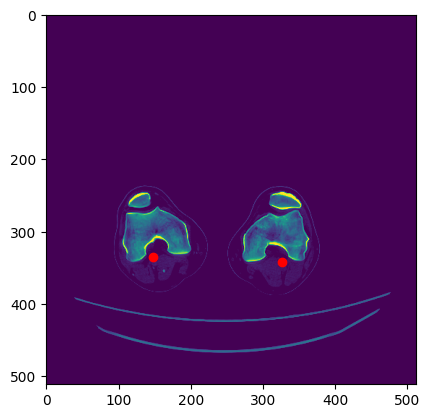

In [14]:
def find_knee_depth(image,bone_low_range=70,bone_high_range=255):
    depth = len(image)
    canvas = copy.deepcopy(image.astype(np.uint8))
    knee_low_index = int(depth/6)
    knee_high_index = int(depth/6 * 3)
    canvas[canvas>bone_high_range] = 0
    canvas[canvas<bone_low_range] = 0
    
    object_areas = list()

    for i in range(knee_low_index,knee_high_index):
        contours, _ = cv2.findContours(canvas[i], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        bounding_rects = [cv2.boundingRect(cnt) for cnt in contours]
        object_areas.append(max([w*h if (w>h and w/h < 3) or (w<h and h/w < 3) else 0 for (_,_,w,h) in bounding_rects],default=0))
    
    max_area_depth = knee_low_index + object_areas.index(max(object_areas))
    contours, _ = cv2.findContours(canvas[max_area_depth], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    bounding_rects = [cv2.boundingRect(cnt) for cnt in contours]
    filtered_bounding_rects = [w*h if (w/h < 3) else 0 for (_,_,w,h) in bounding_rects]
    index_contour = np.argsort(filtered_bounding_rects)[-2:]
    # Fill knee polygon
    mask = np.zeros_like(canvas[0], dtype=np.uint8)
    cv2.drawContours(mask, [contours[index_contour[0]]],-1, 255,1)
    cv2.drawContours(mask, [contours[index_contour[1]]],-1, 255,1)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
    mask = cv2.dilate(mask,kernel,iterations = 2)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    knee_contour = [contours[0],contours[1]]
    return max_area_depth,knee_contour

def extract_arteries_position_from_knee(knee_image,knee_contour,low_filter=30):
    extraction_img = copy.deepcopy(knee_image.astype(np.uint8))
    knee_1,knee_2 = knee_contour
    extraction_img[extraction_img<low_filter]=0
    contours, _ = cv2.findContours(extraction_img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    candidate = list()
    positions = list()
    i=0
    for cnt in contours:
        rect = cv2.minAreaRect(cnt)
        rect_points = cv2.boxPoints(rect).astype(np.uint8)
        #We select only contour between 10 & 100 pixel "draft" areas that are not located in the knee contour
        if (10<np.prod(rect[1])<100 and cv2.contourArea(cnt)>0
        and cv2.pointPolygonTest(knee_1,rect[0],False)<0 
        and cv2.pointPolygonTest(knee_2,rect[0],False) < 0):
            candidate.append(cnt)
            positions.append([cv2.contourArea(cnt),i])
            i+=1
    positions.sort(key=lambda p: p[0],reverse=True)
    vessel1_contour = candidate[int(positions[0][1])]
    vessel2_contour = candidate[int(positions[1][1])]
    M = cv2.moments(vessel1_contour)
    vessel1 = (int(M['m10']/M['m00']),int(M['m01']/M['m00']))
    M = cv2.moments(vessel2_contour)
    vessel2 = (int(M['m10']/M['m00']),int(M['m01']/M['m00']))
    return vessel1,vessel2

knee_depth, knee_contour = find_knee_depth(image_array)
vessel1,vessel2 = extract_arteries_position_from_knee(image_array[knee_depth],knee_contour)

plt.plot([vessel1[0]],[vessel1[1]],marker='o', color='r')
plt.plot([vessel2[0]],[vessel2[1]],marker='o', color='r')
plt.imshow(image_array[knee_depth])
plt.show()